# Deep Learning Hello World

Basic examples for Tensorflow, Pytorch and JAX-based neural networks

In [3]:
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
from tabulate import tabulate
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Feedforward 1: Linear Regression

## Baseline

In [4]:
n = 100
p = 3
train_rate = 0.7

X = np.random.normal(0, 1, size=(n, p))
y = np.sum(X, axis=1) + np.random.normal(0, 0.5, size=n)
print(tabulate(X[-3:], floatfmt='.4f'))
print(tabulate(y[-3:, np.newaxis], floatfmt='.4f'))

n_train = int(n*train_rate)

X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]

-------  -------  -------
-0.8033  -0.0964  -0.2616
 0.4364   0.3072  -0.5614
-1.9863  -0.2541   1.5584
-------  -------  -------
-------
-0.8308
 0.1099
-0.8459
-------


In [5]:
model = LinearRegression()
model.fit(X_train, y_train)
print(f'Train {np.sqrt(mean_squared_error(y_train, model.predict(X_train))):.3f}')
print(f'Test  {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):.3f}')

Train 0.467
Test  0.499


## TF2

https://www.tensorflow.org/tutorials/keras/regression

In [58]:
import tensorflow as tf

def init_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(p, activation='relu', input_shape=(p,)),
        tf.keras.layers.Dense(1),
    ])

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.SGD(0.01),
        metrics=['mae', 'mse'],
    )
    
    return model

model = init_model()
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 4         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


CPU times: user 21 s, sys: 498 ms, total: 21.5 s
Wall time: 19 s


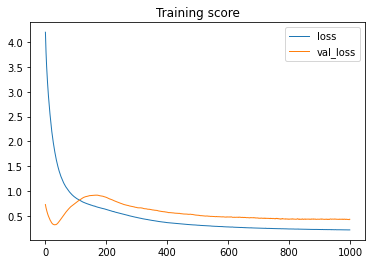

In [59]:
%%time
train_history = model.fit(
    X_train, 
    y_train,
    epochs=1000, 
    validation_split=0.2, 
    verbose=0,
)
_ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)

In [60]:
print(f'Train {np.sqrt(mean_squared_error(y_train, model.predict(X_train))):.3f}')
print(f'Test  {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):.3f}')

Train 0.508
Test  0.519


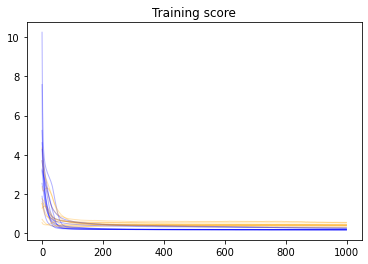

In [61]:
# Model variance
fig, ax = plt.subplots()

for i in range(10):
    model = init_model()

    train_history = model.fit(
        X_train, 
        y_train,
        epochs=1000, 
        validation_split=0.2, 
        verbose=0,
    )
    _ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(
        title='Training score', lw=1, ax=ax, 
        legend=False, color=['blue', 'orange'], alpha=0.3,
    )

## Pytorch


https://towardsdatascience.com/pytorch-tabular-regression-428e9c9ac93

In [54]:
import torch

def init_model():
    model = torch.nn.Sequential(
        torch.nn.Linear(p, p),
        torch.nn.ReLU(),
        torch.nn.Linear(p, 1),
    )

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    loss_func = torch.nn.MSELoss()
    
    return model, optimizer, loss_func

model, optimizer, loss_func = init_model()

print(model)

Sequential(
  (0): Linear(in_features=3, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=1, bias=True)
)


CPU times: user 520 ms, sys: 4.58 ms, total: 525 ms
Wall time: 520 ms


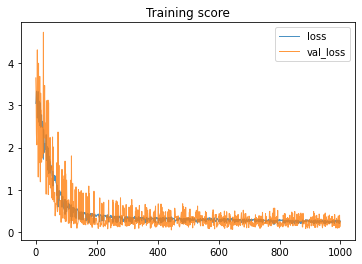

In [55]:
%%time
train_history = defaultdict(list)
for epoch in range(1000):
    X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, train_size=0.8)
    inputs = torch.from_numpy(X_train_1).float()
    outputs = torch.from_numpy(y_train_1[:, np.newaxis]).float()
    val_inputs = torch.from_numpy(X_train_2).float()
    val_outputs = torch.from_numpy(y_train_2[:, np.newaxis]).float()
    
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs_hat = model(inputs)
    loss = loss_func(outputs_hat, outputs)
    loss.backward()
    optimizer.step()
    
    # save training loss
    train_history['loss'].append(loss.item())
    
    # compute validation loss
    with torch.no_grad():
        val_outputs_hat = model(val_inputs)
        val_loss = loss_func(val_outputs_hat, val_outputs)
        train_history['val_loss'].append(val_loss.item())

_ = pd.DataFrame(train_history).plot(title='Training score', lw=1, alpha=0.8)

In [56]:
print(f'Train {np.sqrt(mean_squared_error(y_train, model(torch.from_numpy(X_train).float()).detach().numpy())):.3f}')
print(f'Test  {np.sqrt(mean_squared_error(y_test, model(torch.from_numpy(X_test).float()).detach().numpy())):.3f}')

Train 0.496
Test  0.567


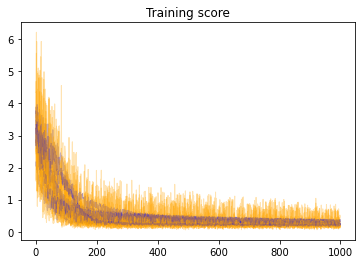

In [53]:
# Model variance
fig, ax = plt.subplots()

for i in range(10):
    model, optimizer, loss_func = init_model()
    
    train_history = defaultdict(list)
    for epoch in range(1000):
        X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, train_size=0.8)
        inputs = torch.from_numpy(X_train_1).float()
        outputs = torch.from_numpy(y_train_1[:, np.newaxis]).float()
        val_inputs = torch.from_numpy(X_train_2).float()
        val_outputs = torch.from_numpy(y_train_2[:, np.newaxis]).float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs_hat = model(inputs)
        loss = loss_func(outputs_hat, outputs)
        loss.backward()
        optimizer.step()

        # save training loss
        train_history['loss'].append(loss.item())

        # compute validation loss
        with torch.no_grad():
            val_outputs_hat = model(val_inputs)
            val_loss = loss_func(val_outputs_hat, val_outputs)
            train_history['val_loss'].append(val_loss.item())
    
    _ = pd.DataFrame(train_history)[['loss', 'val_loss']].plot(
        title='Training score', lw=1, ax=ax, 
        legend=False, color=['blue', 'orange'], alpha=0.3,
    )
    

## Haiku

https://github.com/deepmind/dm-haiku

In [149]:
import jax
from jax import numpy as jnp
from jax import jit as jjit
import haiku as hk

@jjit
def mse(outputs, outputs_hat):
    return (outputs-outputs_hat)**2

@jjit
def loss_fn(inputs, outputs):
    mlp = hk.Sequential([
        hk.Linear(p), 
        jax.nn.relu,
        hk.Linear(1),
    ])
    outputs_hat = mlp(inputs)
    return jnp.mean(mse(outputs, outputs_hat))

# hk.transform allows us to turn this function into a pair of pure functions: init and apply. 
# All JAX transformations require to pass in a pure function for correct behaviour.
# Haiku makes it easy to write them.
loss_obj = hk.transform(loss_fn, apply_rng=True)

# Initial parameter values are typically random. In JAX you need a key in order
# to generate random numbers and so Haiku requires you to pass one in.
rng = jax.random.PRNGKey(42)

# `init` runs your function, as such we need an example input. Typically you can
# pass "dummy" inputs (e.g. ones of the same shape and dtype) since initialization
# is not usually data dependent.
X_train_ = jnp.asarray(X_train)
y_train_ = jnp.asarray(y_train)
X_test_ = jnp.asarray(X_test)
y_test_ = jnp.asarray(y_test)

# The result of `init` is a nested data structure of all the parameters in your
# network. You can pass this into `apply`.
params = loss_obj.init(rng, X_train_, y_train_)
print(params)

# Gradient update
@jjit
def sgd(param, update):
    return param - 0.01 * update

frozendict({
  'linear': frozendict({
              'b': DeviceArray([0., 0., 0.], dtype=float32),
              'w': DeviceArray([[-0.85853237,  0.12908897, -0.13488792],
                                [ 0.24561784, -0.20738742,  0.15554754],
                                [-0.06070174,  0.3124922 ,  0.18682341]], dtype=float32),
            }),
  'linear_1': frozendict({
                'b': DeviceArray([0.], dtype=float32),
                'w': DeviceArray([[ 0.37143728],
                                  [-0.6535752 ],
                                  [ 0.5136476 ]], dtype=float32),
              }),
})


In [152]:
# ZERO GRAD??
jax.grad(loss_obj.apply)(params, None, X_train_, y_train_)

frozendict({
  'linear': frozendict({
              'b': array([0., 0., 0.], dtype=float32),
              'w': array([[0., 0., 0.],
                          [0., 0., 0.],
                          [0., 0., 0.]], dtype=float32),
            }),
  'linear_1': frozendict({
                'b': array([0.], dtype=float32),
                'w': array([[0.],
                            [0.],
                            [0.]], dtype=float32),
              }),
})

In [151]:
%%time

train_history = defaultdict(list)
for epoch in range(10):
    # The `apply` function allows you to inject parameter values into your function.
#     grads = jax.grad(loss_obj.apply)(params, None, X_train_, y_train_)
#     loss = loss_obj.apply(params, None, X_train_, y_train_)
    loss, grads = jax.value_and_grad(loss_obj.apply)(params, None, X_train_, y_train_)
    params = jax.tree_multimap(sgd, params, grads)
    
    # Record train loss
    loss = jax.device_get(loss)
    train_history['loss'].append(loss)

CPU times: user 50.6 ms, sys: 4.25 ms, total: 54.9 ms
Wall time: 46 ms


## Flax

https://github.com/google/flax

In [63]:
# TODO